# 2. Data Balance with Oversampling
---

In this notebook, we will look at the hashtags labels for each image, and fix the imbalance.

## Import Libraries (the following cells are copied from notebook 1)

In [25]:
import pandas as pd
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sys
sys.path.append("../src")

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [26]:
DATA_LIST = "../HARRISON/data_list_similarity_balanced.txt"
TAG_LIST = "../HARRISON/tag_list_similarity_balanced.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
#filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target.head(5)

,filename,labels
0,sea_image_50.jpg,instagram sea trip
1,sea_image_1284.jpg,sea
2,sea_image_1122.jpg,sea
3,sea_image_1679.jpg,bali island japan sea
4,sea_image_1736.jpg,adventure roadtrip sand sea thailand trip


In [27]:
# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
X_df = pd.DataFrame(X.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, X_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = X_df.shape[1]

## Visualize the data imbalance

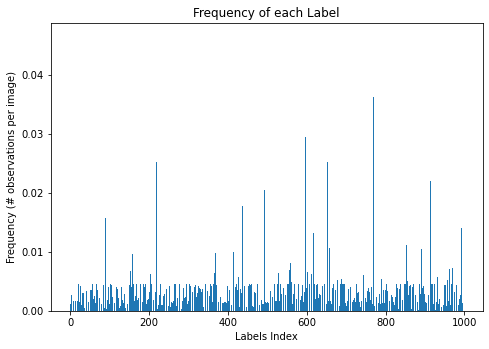

Variance in Frequency: 1.8725838171905137e-05


In [28]:
def display_probability_bar_graph(label_series):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    row_names = np.arange(0,label_series.shape[0])#label_prob_df.index
    ax.bar(row_names,label_series)
    ax.set_title('Frequency of each Label')
    ax.set_ylabel('Frequency (# observations per image)')
    ax.set_xlabel('Labels Index')
    plt.show()
    print("Variance in Frequency:",label_series.var())
display_probability_bar_graph(X_df.sum(axis=0) / X_df.shape[0])

## Balance the data
Idea: We need to duplicate rows (images), so that all labels have the same frequency. If possible, we'd like to minimize the number of images duplicated. (Maybe also make small changes (crop or rotate) on the duplications)

#### Implementation 1: 
Solve the equation X(v)=0 ! (Find the kernel of X)

In [29]:
a = X_df.to_numpy()
row_multiples = null_space(a)

MemoryError: Unable to allocate 24.5 GiB for an array with shape (57383, 57383) and data type float64

Note the memory allocation issue! We will have to try something else.

#### Implementation 2:
We greedily choose a row with the least-represented labels to duplicate. Every iteration we duplicate the least-represented k rows.

In [30]:
#metrics for row duplication (more iterations and lower k yields better performance but slower)
num_iterations = 1000
k = 50 #number of images to duplicate per iteration

In [31]:
#dataframe appended to X_df in order to balance it
duplication_list_df = pd.DataFrame()

#frequency of each label in dataset
label_freq_df = X_df.sum(axis=0)

#find images to duplicate in each iteration
for i in range(num_iterations):
    
    #find probability of each label
    label_prob_df = label_freq_df / (X_df.shape[0] + i*k)
    label_prob_df_mean = label_prob_df.mean() 
    
    #evaluate score of each instance (score is an arbitary metric: number of labels that are underrepresented)
    labels_above_mean_mask = 1 * (label_prob_df < label_prob_df_mean)
    instance_scores = X_df.dot(labels_above_mean_mask) + (0 == X_df).dot(labels_above_mean_mask == 0)
    
    #find images to duplicate
    duplicated_rows_indices = np.argpartition(-1 * instance_scores, k)[:k]
    
    #mask the rows to duplicate (only keep tags less frequent than mean)
    duplicated_rows = X_df.iloc[duplicated_rows_indices] * labels_above_mean_mask
    
    #update the label frequency using k least likely instances
    label_freq_df += duplicated_rows.sum(axis=0)
    
    #update the duplication dict   
    duplication_list_df = duplication_list_df.append(duplicated_rows)
    
    #check variance and print
    new_var = label_prob_df.var()
    print("Completed",i+1,"iterations of",k,"duplications. Previous Variance:",label_prob_df.var())
        
print('Done!')
    

Completed 1 iterations of 50 duplications. Previous Variance: 1.8725838171905137e-05
Completed 2 iterations of 50 duplications. Previous Variance: 1.867255351428436e-05
Completed 3 iterations of 50 duplications. Previous Variance: 1.862006896157284e-05
Completed 4 iterations of 50 duplications. Previous Variance: 1.856836831634014e-05
Completed 5 iterations of 50 duplications. Previous Variance: 1.8517676856273926e-05
Completed 6 iterations of 50 duplications. Previous Variance: 1.8466978246680376e-05
Completed 7 iterations of 50 duplications. Previous Variance: 1.8416517968470972e-05
Completed 8 iterations of 50 duplications. Previous Variance: 1.8366685407999535e-05
Completed 9 iterations of 50 duplications. Previous Variance: 1.831775275564242e-05
Completed 10 iterations of 50 duplications. Previous Variance: 1.8270583578997646e-05
Completed 11 iterations of 50 duplications. Previous Variance: 1.8222667518495048e-05
Completed 12 iterations of 50 duplications. Previous Variance: 1.81

Completed 98 iterations of 50 duplications. Previous Variance: 1.4787592483810126e-05
Completed 99 iterations of 50 duplications. Previous Variance: 1.4753580498772602e-05
Completed 100 iterations of 50 duplications. Previous Variance: 1.471900814766178e-05
Completed 101 iterations of 50 duplications. Previous Variance: 1.4686807510381695e-05
Completed 102 iterations of 50 duplications. Previous Variance: 1.465350349726504e-05
Completed 103 iterations of 50 duplications. Previous Variance: 1.4620266271057646e-05
Completed 104 iterations of 50 duplications. Previous Variance: 1.4587839632669362e-05
Completed 105 iterations of 50 duplications. Previous Variance: 1.4554724466188764e-05
Completed 106 iterations of 50 duplications. Previous Variance: 1.4521457239804787e-05
Completed 107 iterations of 50 duplications. Previous Variance: 1.4488535304121643e-05
Completed 108 iterations of 50 duplications. Previous Variance: 1.4458124220036134e-05
Completed 109 iterations of 50 duplications. Pr

Completed 193 iterations of 50 duplications. Previous Variance: 1.211749814832695e-05
Completed 194 iterations of 50 duplications. Previous Variance: 1.2091730749058544e-05
Completed 195 iterations of 50 duplications. Previous Variance: 1.20692342392957e-05
Completed 196 iterations of 50 duplications. Previous Variance: 1.2045658285154857e-05
Completed 197 iterations of 50 duplications. Previous Variance: 1.2020088717204588e-05
Completed 198 iterations of 50 duplications. Previous Variance: 1.1998394585556157e-05
Completed 199 iterations of 50 duplications. Previous Variance: 1.1976217028031387e-05
Completed 200 iterations of 50 duplications. Previous Variance: 1.195063714898262e-05
Completed 201 iterations of 50 duplications. Previous Variance: 1.1929040344053761e-05
Completed 202 iterations of 50 duplications. Previous Variance: 1.1906219062968063e-05
Completed 203 iterations of 50 duplications. Previous Variance: 1.1882073566656172e-05
Completed 204 iterations of 50 duplications. Pr

Completed 288 iterations of 50 duplications. Previous Variance: 1.0114837654542355e-05
Completed 289 iterations of 50 duplications. Previous Variance: 1.009373897692956e-05
Completed 290 iterations of 50 duplications. Previous Variance: 1.0072540034041112e-05
Completed 291 iterations of 50 duplications. Previous Variance: 1.0056183819489762e-05
Completed 292 iterations of 50 duplications. Previous Variance: 1.003796615665487e-05
Completed 293 iterations of 50 duplications. Previous Variance: 1.0018293928499928e-05
Completed 294 iterations of 50 duplications. Previous Variance: 1.000095280650124e-05
Completed 295 iterations of 50 duplications. Previous Variance: 9.98388213610618e-06
Completed 296 iterations of 50 duplications. Previous Variance: 9.963738637120993e-06
Completed 297 iterations of 50 duplications. Previous Variance: 9.947623525912e-06
Completed 298 iterations of 50 duplications. Previous Variance: 9.929678769774597e-06
Completed 299 iterations of 50 duplications. Previous 

Completed 384 iterations of 50 duplications. Previous Variance: 8.516670230101598e-06
Completed 385 iterations of 50 duplications. Previous Variance: 8.501038094591403e-06
Completed 386 iterations of 50 duplications. Previous Variance: 8.487298335083241e-06
Completed 387 iterations of 50 duplications. Previous Variance: 8.472506343574431e-06
Completed 388 iterations of 50 duplications. Previous Variance: 8.456302181091004e-06
Completed 389 iterations of 50 duplications. Previous Variance: 8.442963554918408e-06
Completed 390 iterations of 50 duplications. Previous Variance: 8.429382783176084e-06
Completed 391 iterations of 50 duplications. Previous Variance: 8.413743983982574e-06
Completed 392 iterations of 50 duplications. Previous Variance: 8.397281301101803e-06
Completed 393 iterations of 50 duplications. Previous Variance: 8.384395471826351e-06
Completed 394 iterations of 50 duplications. Previous Variance: 8.370505803210748e-06
Completed 395 iterations of 50 duplications. Previous 

Completed 480 iterations of 50 duplications. Previous Variance: 7.237014214286867e-06
Completed 481 iterations of 50 duplications. Previous Variance: 7.226336526067354e-06
Completed 482 iterations of 50 duplications. Previous Variance: 7.215359092805586e-06
Completed 483 iterations of 50 duplications. Previous Variance: 7.202120269862635e-06
Completed 484 iterations of 50 duplications. Previous Variance: 7.191661181916352e-06
Completed 485 iterations of 50 duplications. Previous Variance: 7.180123760505821e-06
Completed 486 iterations of 50 duplications. Previous Variance: 7.16734483067937e-06
Completed 487 iterations of 50 duplications. Previous Variance: 7.153414418872798e-06
Completed 488 iterations of 50 duplications. Previous Variance: 7.142938019225603e-06
Completed 489 iterations of 50 duplications. Previous Variance: 7.131294487847295e-06
Completed 490 iterations of 50 duplications. Previous Variance: 7.119021245498391e-06
Completed 491 iterations of 50 duplications. Previous V

Completed 576 iterations of 50 duplications. Previous Variance: 6.214523355472384e-06
Completed 577 iterations of 50 duplications. Previous Variance: 6.203861424147813e-06
Completed 578 iterations of 50 duplications. Previous Variance: 6.1953524760259455e-06
Completed 579 iterations of 50 duplications. Previous Variance: 6.185502490627857e-06
Completed 580 iterations of 50 duplications. Previous Variance: 6.175002845544175e-06
Completed 581 iterations of 50 duplications. Previous Variance: 6.163738803407311e-06
Completed 582 iterations of 50 duplications. Previous Variance: 6.155459421108401e-06
Completed 583 iterations of 50 duplications. Previous Variance: 6.14595378538392e-06
Completed 584 iterations of 50 duplications. Previous Variance: 6.135962369337959e-06
Completed 585 iterations of 50 duplications. Previous Variance: 6.127358539424446e-06
Completed 586 iterations of 50 duplications. Previous Variance: 6.118307334642601e-06
Completed 587 iterations of 50 duplications. Previous 

Completed 672 iterations of 50 duplications. Previous Variance: 5.371045763838633e-06
Completed 673 iterations of 50 duplications. Previous Variance: 5.363505463829917e-06
Completed 674 iterations of 50 duplications. Previous Variance: 5.3551549501708045e-06
Completed 675 iterations of 50 duplications. Previous Variance: 5.34619539602047e-06
Completed 676 iterations of 50 duplications. Previous Variance: 5.339192459359526e-06
Completed 677 iterations of 50 duplications. Previous Variance: 5.332109231461707e-06
Completed 678 iterations of 50 duplications. Previous Variance: 5.323510482160385e-06
Completed 679 iterations of 50 duplications. Previous Variance: 5.316916262036133e-06
Completed 680 iterations of 50 duplications. Previous Variance: 5.309139353823971e-06
Completed 681 iterations of 50 duplications. Previous Variance: 5.300839028689341e-06
Completed 682 iterations of 50 duplications. Previous Variance: 5.292178390750711e-06
Completed 683 iterations of 50 duplications. Previous 

Completed 768 iterations of 50 duplications. Previous Variance: 4.675368661895891e-06
Completed 769 iterations of 50 duplications. Previous Variance: 4.6694998243050455e-06
Completed 770 iterations of 50 duplications. Previous Variance: 4.662350391910227e-06
Completed 771 iterations of 50 duplications. Previous Variance: 4.654461735227774e-06
Completed 772 iterations of 50 duplications. Previous Variance: 4.648801290160879e-06
Completed 773 iterations of 50 duplications. Previous Variance: 4.642467226284803e-06
Completed 774 iterations of 50 duplications. Previous Variance: 4.635796031382373e-06
Completed 775 iterations of 50 duplications. Previous Variance: 4.630208619667729e-06
Completed 776 iterations of 50 duplications. Previous Variance: 4.624071889770982e-06
Completed 777 iterations of 50 duplications. Previous Variance: 4.61693103834394e-06
Completed 778 iterations of 50 duplications. Previous Variance: 4.609169717966987e-06
Completed 779 iterations of 50 duplications. Previous 

Completed 864 iterations of 50 duplications. Previous Variance: 4.0974334663038985e-06
Completed 865 iterations of 50 duplications. Previous Variance: 4.092765312604504e-06
Completed 866 iterations of 50 duplications. Previous Variance: 4.088012444514365e-06
Completed 867 iterations of 50 duplications. Previous Variance: 4.082147412674862e-06
Completed 868 iterations of 50 duplications. Previous Variance: 4.075257244595791e-06
Completed 869 iterations of 50 duplications. Previous Variance: 4.070848810564734e-06
Completed 870 iterations of 50 duplications. Previous Variance: 4.065422984020156e-06
Completed 871 iterations of 50 duplications. Previous Variance: 4.059320480928797e-06
Completed 872 iterations of 50 duplications. Previous Variance: 4.054314675446547e-06
Completed 873 iterations of 50 duplications. Previous Variance: 4.049057892368144e-06
Completed 874 iterations of 50 duplications. Previous Variance: 4.042834706571256e-06
Completed 875 iterations of 50 duplications. Previous

Completed 959 iterations of 50 duplications. Previous Variance: 3.613467805848758e-06
Completed 960 iterations of 50 duplications. Previous Variance: 3.6078010005927073e-06
Completed 961 iterations of 50 duplications. Previous Variance: 3.603809450129858e-06
Completed 962 iterations of 50 duplications. Previous Variance: 3.599522632466288e-06
Completed 963 iterations of 50 duplications. Previous Variance: 3.5947465148598787e-06
Completed 964 iterations of 50 duplications. Previous Variance: 3.5908218812822873e-06
Completed 965 iterations of 50 duplications. Previous Variance: 3.5869471402694313e-06
Completed 966 iterations of 50 duplications. Previous Variance: 3.581593756384995e-06
Completed 967 iterations of 50 duplications. Previous Variance: 3.576156268531041e-06
Completed 968 iterations of 50 duplications. Previous Variance: 3.572304670024038e-06
Completed 969 iterations of 50 duplications. Previous Variance: 3.56803397794729e-06
Completed 970 iterations of 50 duplications. Previo

In [36]:
#duplicate the lines specified in duplication_list
balanced_X_df = X_df.append(duplication_list_df)

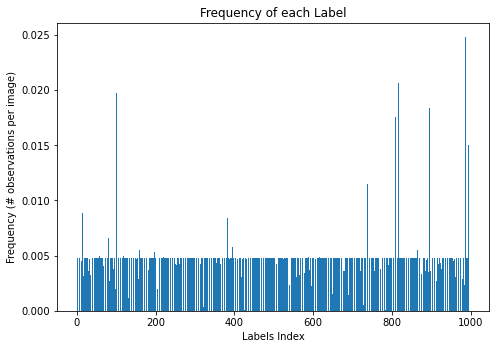

Variance in Frequency: 3.4234666824466294e-06


In [37]:
display_probability_bar_graph(balanced_X_df.sum(axis=0) / balanced_X_df.shape[0])

## Save the dataframes as a files

In [38]:
import os
tag_list_pathname = os.path.join("..","HARRISON","tag_list_oversampled.txt")
data_list_pathname = os.path.join("..","HARRISON","data_list_oversampled.txt")

tag_list_oversampled_series = balanced_X_df.dot((balanced_X_df.columns.to_numpy() + " "))
data_list_oversampled_series = target.loc[balanced_X_df.index,'filename']

tag_list_oversampled_series.to_csv(tag_list_pathname,header=False,index=False)
data_list_oversampled_series.to_csv(data_list_pathname,header=False,index=False)